In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

sns.set_style("whitegrid")

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


In [8]:
df = pd.read_table("swim.dat", header=None, delim_whitespace=' ')
df.columns = [f'w{i+1}' for i in range(6)]
df

,w1,w2,w3,w4,w5,w6
0,23.1,23.2,22.9,22.9,22.8,22.7
1,23.2,23.1,23.4,23.5,23.5,23.4
2,22.7,22.6,22.8,22.8,22.9,22.8
3,23.7,23.6,23.7,23.5,23.5,23.4


<AxesSubplot:>

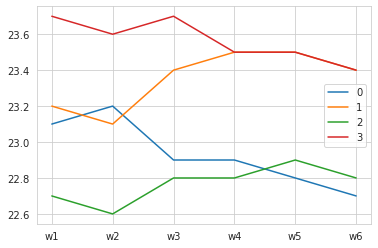

In [12]:
df.T.plot()

In [296]:
X = pd.DataFrame(np.c_[np.ones(df.shape[1]), np.arange(df.shape[1]) + 1], columns=['intercept', 'week'])
y = df.iloc[1, :]

In [297]:
def bayes_ols(X, y=None):
    N, p = X.shape
    with pm.Model() as model:
        X_tt = pm.Data("X_tt", X)
        y_tt = pm.Data("y_tt", y if y is not None else np.zeros(N))

        β = pm.MvNormal('β', mu=np.array([23, 0]), cov=np.array([[0.2, 0], [0, 0.2]]), shape=(p, ))
        τ = pm.Gamma('τ', alpha=1/2, beta=(1*1)/2)

        likelihood = pm.Normal('y', mu=pm.math.dot(X_tt, β), tau=τ, observed=y_tt)
    
    return model

In [298]:
# generating graphs
models = {i: {'model': bayes_ols(X, y=df.iloc[i, :])} for i in range(4)}

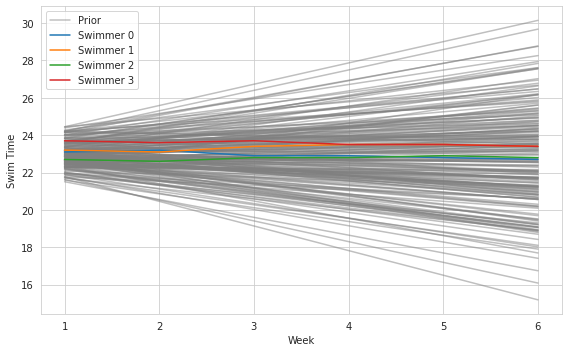

In [299]:
# prior checks
prior_ss = pm.sample_prior_predictive(200, model=models[0]['model'], random_seed=602)

fig, ax = plt.subplots(figsize=(8, 5))

for b in prior_ss['β']:
    ax.plot(X['week'], X @ b, color='grey', alpha=0.5)

ax.plot(X['week'], X @ b, color='grey', alpha=0.5, label='Prior')

for i in range(4):
    ax.plot(X['week'], df.iloc[i, :], label=f'Swimmer {i}')

ax.legend()
ax.set_xlabel("Week")
ax.set_ylabel("Swim Time")
fig.tight_layout()
fig.show()

In [300]:
for i in range(4):
    post_ss = pm.sample(2000, tune=1000, model=models[i]['model'], return_inferencedata=True)
    models[i]['post_ss'] = post_ss

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'τ'}>,
        <AxesSubplot:title={'center':'τ'}>]], dtype=object)

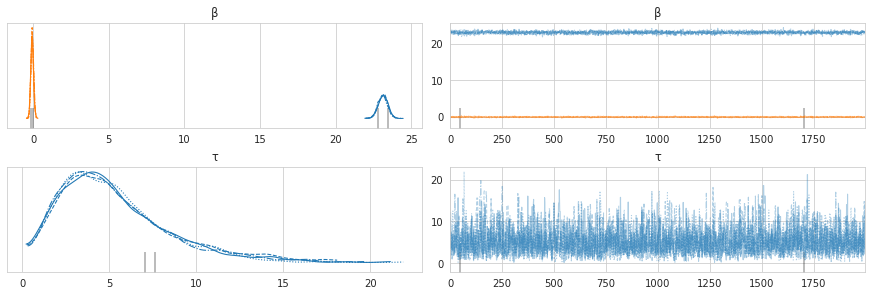

In [301]:
az.plot_trace(models[0]['post_ss'])

In [302]:
for i in range(4):
    post_ss = models[i]['post_ss']
    X_test = pd.DataFrame([[1, 2]], columns=['intercept', 'week'])
    pp = pm.sample_posterior_predictive(post_ss, samples=2000, model=bayes_ols(X=X_test, y=None))
    models[i]['pp'] = pp

/home/ztang484/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ztang484/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ztang484/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ztang484/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [303]:
P = pd.DataFrame({i: models[i]['pp']['y'].ravel() for i in range(4)})
P.columns = [f'Swimmer {i}' for i in range(4)]

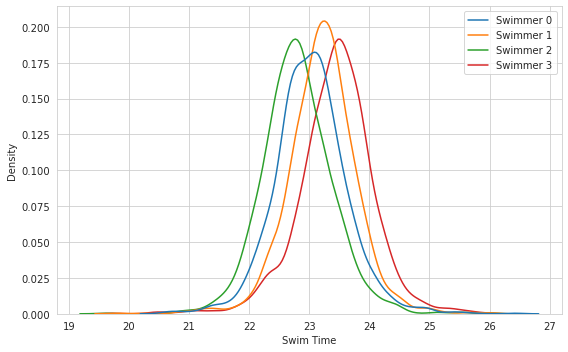

In [307]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(P, ax=ax)
ax.set_xlabel('Swim Time')
fig.tight_layout()
fig.show()

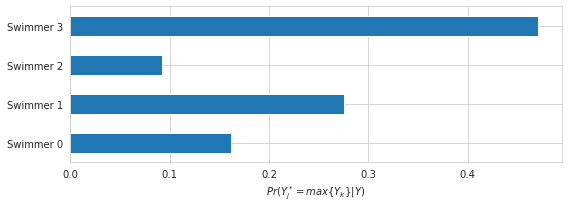

In [320]:
fig, ax = plt.subplots(figsize=(8, 3))
sr = pd.get_dummies(P.apply(np.argmax, axis=1)).mean()
sr.index = P.columns
sr.plot(kind='barh', ax=ax)
ax.set_xlabel("$Pr(Y_j^* = max\{Y_k\}|Y)$")
fig.tight_layout()
fig.show()